<h1>Provenance-Aware Integrity Monitoring with 
    Linux Security Identifiers
</h1>
<br>
<br>
<br>
<br>
<br>
<br>
<h3 style="color:gray"><strong>Linux Foundation</strong></h3>
<h3><strong>Linux Security Summit North America 2024</strong></h3>
<br>
<br>
<br>


<h4 style="color:gray">IBM Research</h4>

In [41]:
import sys, os, json
import numpy as np
import pandas as pd
import plotly.express as px

from sysflow.graphlet import Graphlet, EVT_FIELDS, SID_FIELDS, TAGS_FIELDS

pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

cols = EVT_FIELDS + SID_FIELDS + TAGS_FIELDS

data='data/lss/crond-httpd'

In [ ]:
#@title Initial Colab setup...

# remove colab sample_data
!rm -rf sample_data/

# download datasets
!rm -rf /tmp/sf-lab; git clone -b talk/lssna24 https://github.com/sysflow-telemetry/sf-lab.git /tmp/sf-lab

# add symlink to working directory
!unlink data; ln -s /tmp/sf-lab/pynb/data data
!unlink policies; ln -s /tmp/sf-lab/pynb/policies policies

# install sysflow tooling
!pip install 'sysflow-tools@git+https://github.com/sysflow-telemetry/sf-apis.git@0.5.1-selinux-labels#subdirectory=py3'

# install colab-xterm for interactive terminal
!pip install colab-xterm

# install jq cli
!apt-get install jq

## Agenda

### Part 1: SysFlow provenance collection

### Part 2: Provenace tracking with Security Identifiers

## SysFlow Provenance Collection

In [25]:
# Build the system provenance graph from the sysflow traces (data). Define tagging rules as declarative yaml files. 
g = Graphlet(data, defs=['policies/integrity.yaml', 'policies/ttps.yaml'])

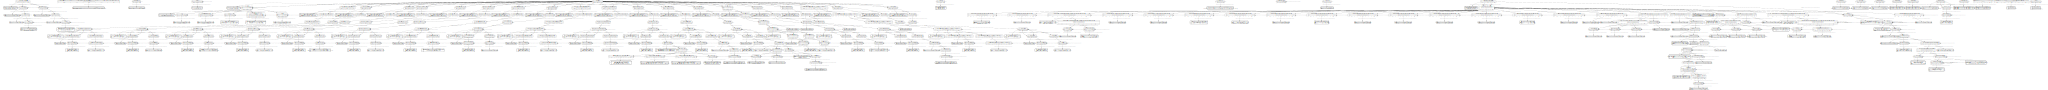

In [35]:
# Whole-system proveance graph
g.view()

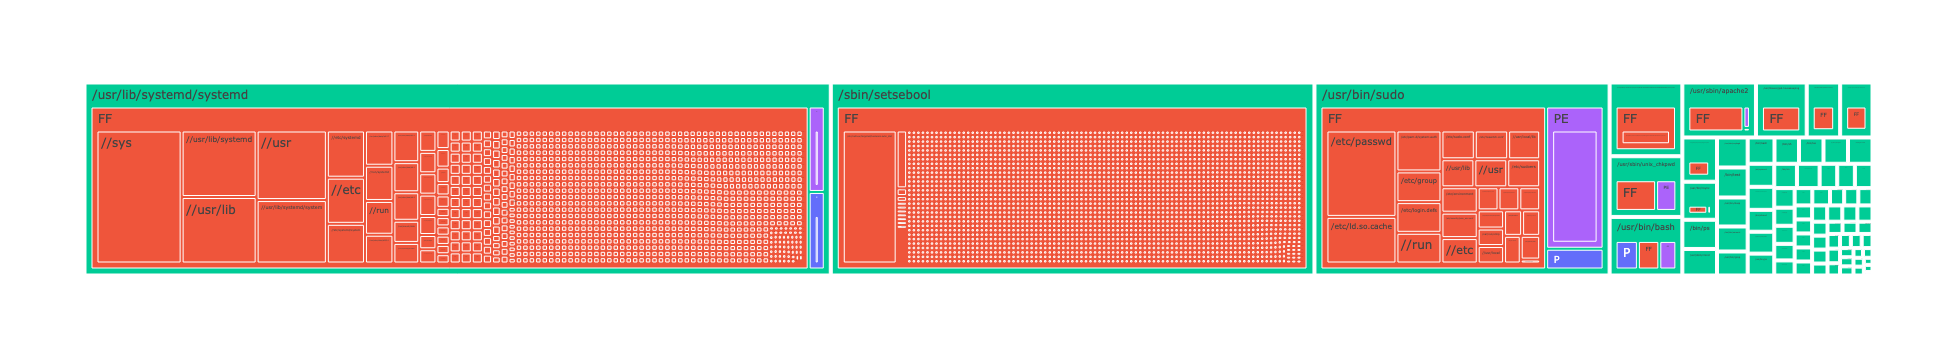

In [43]:
# A treemap visualization of system behaviors
df = g.data()
container_type = df.groupby(['proc.exe','proc.args','pproc.exe','type','res']).size().reset_index(name='count')
cluster = px.treemap(container_type, path=['proc.exe','type','res'], values='count',
                  color='type', 
                  hover_data=['proc.exe','proc.args','pproc.exe','type','res'], 
                  color_discrete_sequence=px.colors.qualitative.Plotly) 
cluster.show()

In [13]:
# The number of records in this provenance graph is too large for meaningful security analysis. 
g.data().shape

(11256, 79)

In [13]:
# We could filter the records by looking for specific processes...
df = g.data()[cols]
df[df['proc.exe'].str.contains('apache2')]

ts_uts type      opflags  proc.pid proc.tid pproc.pid           proc.exe     proc.args                 pproc.exe          proc.sid                           proc.selabel          file.sid                             file.selabel                                                   tags
6759  1713310839099580907   FF  O        T      58837    58837         1  /usr/sbin/apache2  -DFOREGROUND  /usr/lib/systemd/systemd  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0  2533274790395967               system_u:object_r:bin_t:s0  ([PotentialNetworkAttackVector], {vector:network}, 1)
6781  1713310839108120376   PE         EXEC     58837    58837         1  /usr/sbin/apache2  -DFOREGROUND  /usr/lib/systemd/systemd  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0              None                                     None  ([PotentialNetworkAttackVector], {vector:network}, 1)
6782  1713310839108248315   FF  O     M C       58837    58837         1  /usr/sbin/apache2  -DFOREGROUND  /usr/lib/systemd/systemd  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0     9895604650044   unconfined_u:object_r:ld_so_cache_t:s0  ([PotentialNetworkAttackVector], {vector:network}, 1)
6818  1713310839141964501   FF  O   R   C       58837    58837         1  /usr/sbin/apache2  -DFOREGROUND  /usr/lib/systemd/systemd  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0               136           unconfined_u:object_r:etc_t:s0  ([PotentialNetworkAttackVector], {vector:network}, 1)
6819  1713310839142119869   FF  O   R   C       58837    58837         1  /usr/sbin/apache2  -DFOREGROUND  /usr/lib/systemd/systemd  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0  2533274790396480  unconfined_u:object_r:httpd_config_t:s0  ([PotentialNetworkAttackVector], {vector:network}, 1)
...                   ...  ...          ...       ...      ...       ...                ...           ...                       ...               ...                                    ...               ...                                      ...                                                    ...
7362  1713310839424159801   FF     W     T      58849    58852     58837  /usr/sbin/apache2  -DFOREGROUND         /usr/sbin/apache2  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0       38654706251     unconfined_u:object_r:httpd_log_t:s0  ([PotentialNetworkAttackVector], {vector:network}, 1)
8374  1713310865248935360   PE         EXIT     58848    58848     58837  /usr/sbin/apache2  -DFOREGROUND         /usr/sbin/apache2  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0              None                                     None  ([PotentialNetworkAttackVector], {vector:network}, 1)
8375  1713310865250890968   PE         EXIT     58849    58849     58837  /usr/sbin/apache2  -DFOREGROUND         /usr/sbin/apache2  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0              None                                     None  ([PotentialNetworkAttackVector], {vector:network}, 1)
8376  1713310865251097161   PE         EXIT     58850    58850     58837  /usr/sbin/apache2  -DFOREGROUND         /usr/sbin/apache2  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0              None                                     None  ([PotentialNetworkAttackVector], {vector:network}, 1)
8378  1713310865278250407   PE         EXIT     58837    58837         1  /usr/sbin/apache2  -DFOREGROUND  /usr/lib/systemd/systemd  2533274790396484  unconfined_u:object_r:httpd_exec_t:s0              None                                     None  ([PotentialNetworkAttackVector], {vector:network}, 1)

[132 rows x 14 columns]

## Provenance tracking with security identifiers
- **Behavioral graphlets**
  - Compact provenance graphs
  - Coalesce process events, file flows, and network flows based on control flow path
- **Security labels derived from attack graphs**
  - Enhance the semantics of the provenance graph stream with access control labels 
  - Compute integrity boundaries between processes  
- **Security analysis**
  - Enable algorithmic attack detection
  - Attacker (attack operations) and victim behaviors (victim uses) are captured and used to detect attacks

## Integrity rules

```
- rule: Low Integrity Object
  desc: Labels an object as low integrity based on its security identifier
  condition: sf.file.selabel pmatch (low_integrity_object_identifiers)    
  action: [tag]
  tags: [integrity:low]
  
- rule: High Integrity Object
  desc: Labels an object as high integrity based on its security identifier
  condition: sf.proc.selabel pmatch (potential_victim_identifiers)
  action: [tag]
  tags: [integrity:high]
  
- rule: Potential Network Attack Vector
  desc: Labels an object as high integrity based on its security identifier
  condition: sf.proc.selabel pmatch (potential_network_attack_vector_identifiers)
  action: [tag]
  tags: [vector:network]
```



## Attack Scenario: Shellshock (CVE-2014–6271)
<center>
    <img style="margin:0px; width:80%; padding:150px;" src="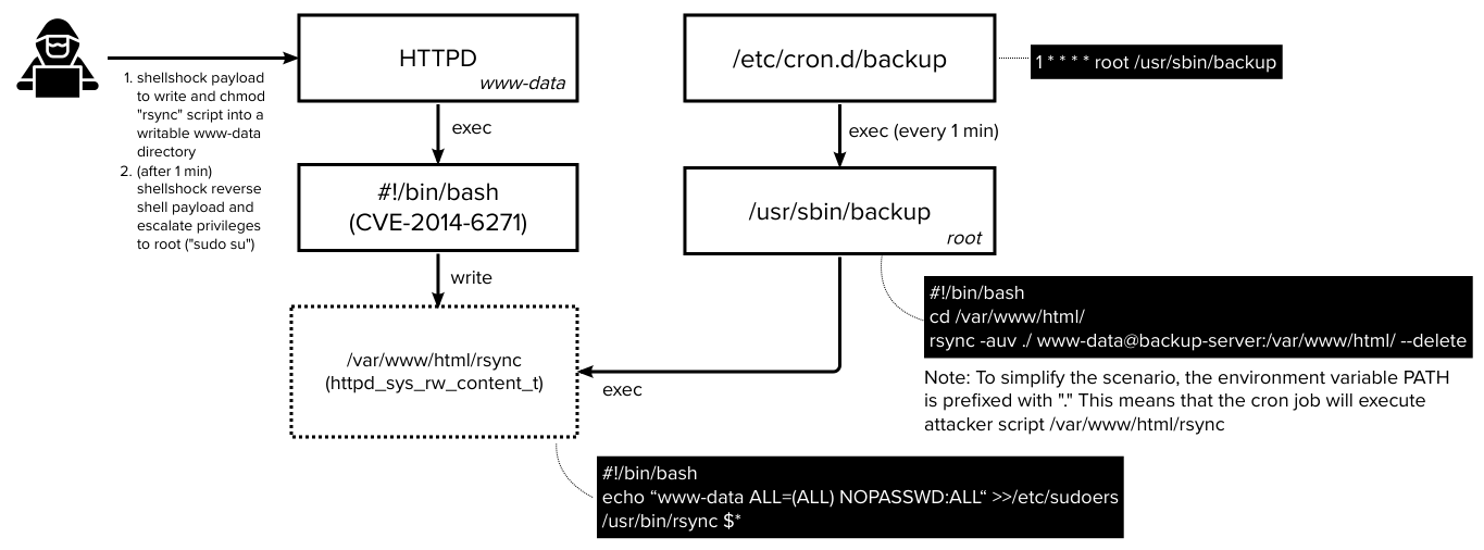
"/>
</center>

## Searching for security integrity violations

In [36]:
# Use security identifiers to find integrity policy violations (e.g., low integrity objects affecting higher integrity victim processes)
def low_integrity_object(df):    
    return len(df[(df['tags'].astype(str).str.contains('integrity:low'))])>0

def potential_victim_process(df): 
    return len(df[(df['tags'].astype(str).str.contains('integrity:high'))])>0


proc = lambda n: potential_victim_process(n.df())
obj = lambda n: low_integrity_object(n.df())

g1 = g.findPaths(proc, obj, prune=True) \
      .attackGraph() 

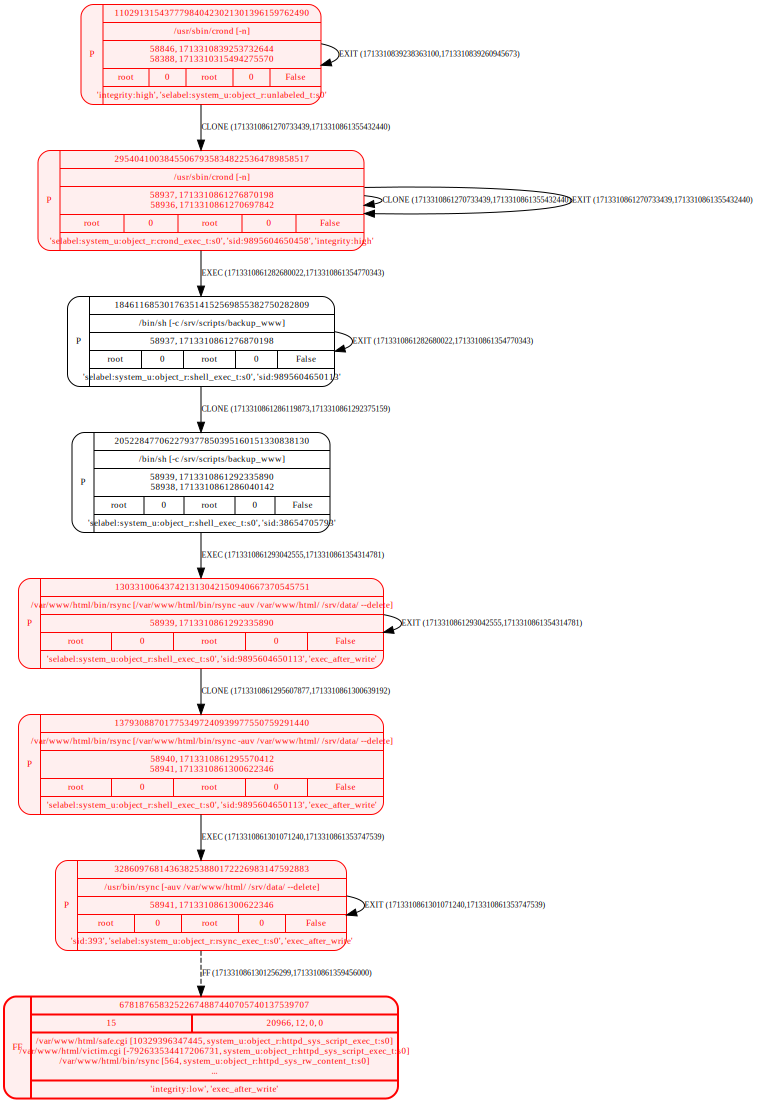

In [30]:
g1.view(withoid=True, ttps=True)

## Uncover the complete attack

In [28]:
def low_integrity_object(df):    
    return len(df[(df['tags'].astype(str).str.contains('integrity:low'))])>0

def potential_victim_process(df): 
    return len(df[(df['tags'].astype(str).str.contains('integrity:high'))])>0

def potential_attack_vector(df): 
    return len(df[(df['tags'].astype(str).str.contains('vector:network'))])>0


proc = lambda n: potential_victim_process(n.df()) or potential_attack_vector(n.df())
obj = lambda n: low_integrity_object(n.df())

g2 = g.findPaths(proc, obj, prune=True) \
      .attackGraph() 

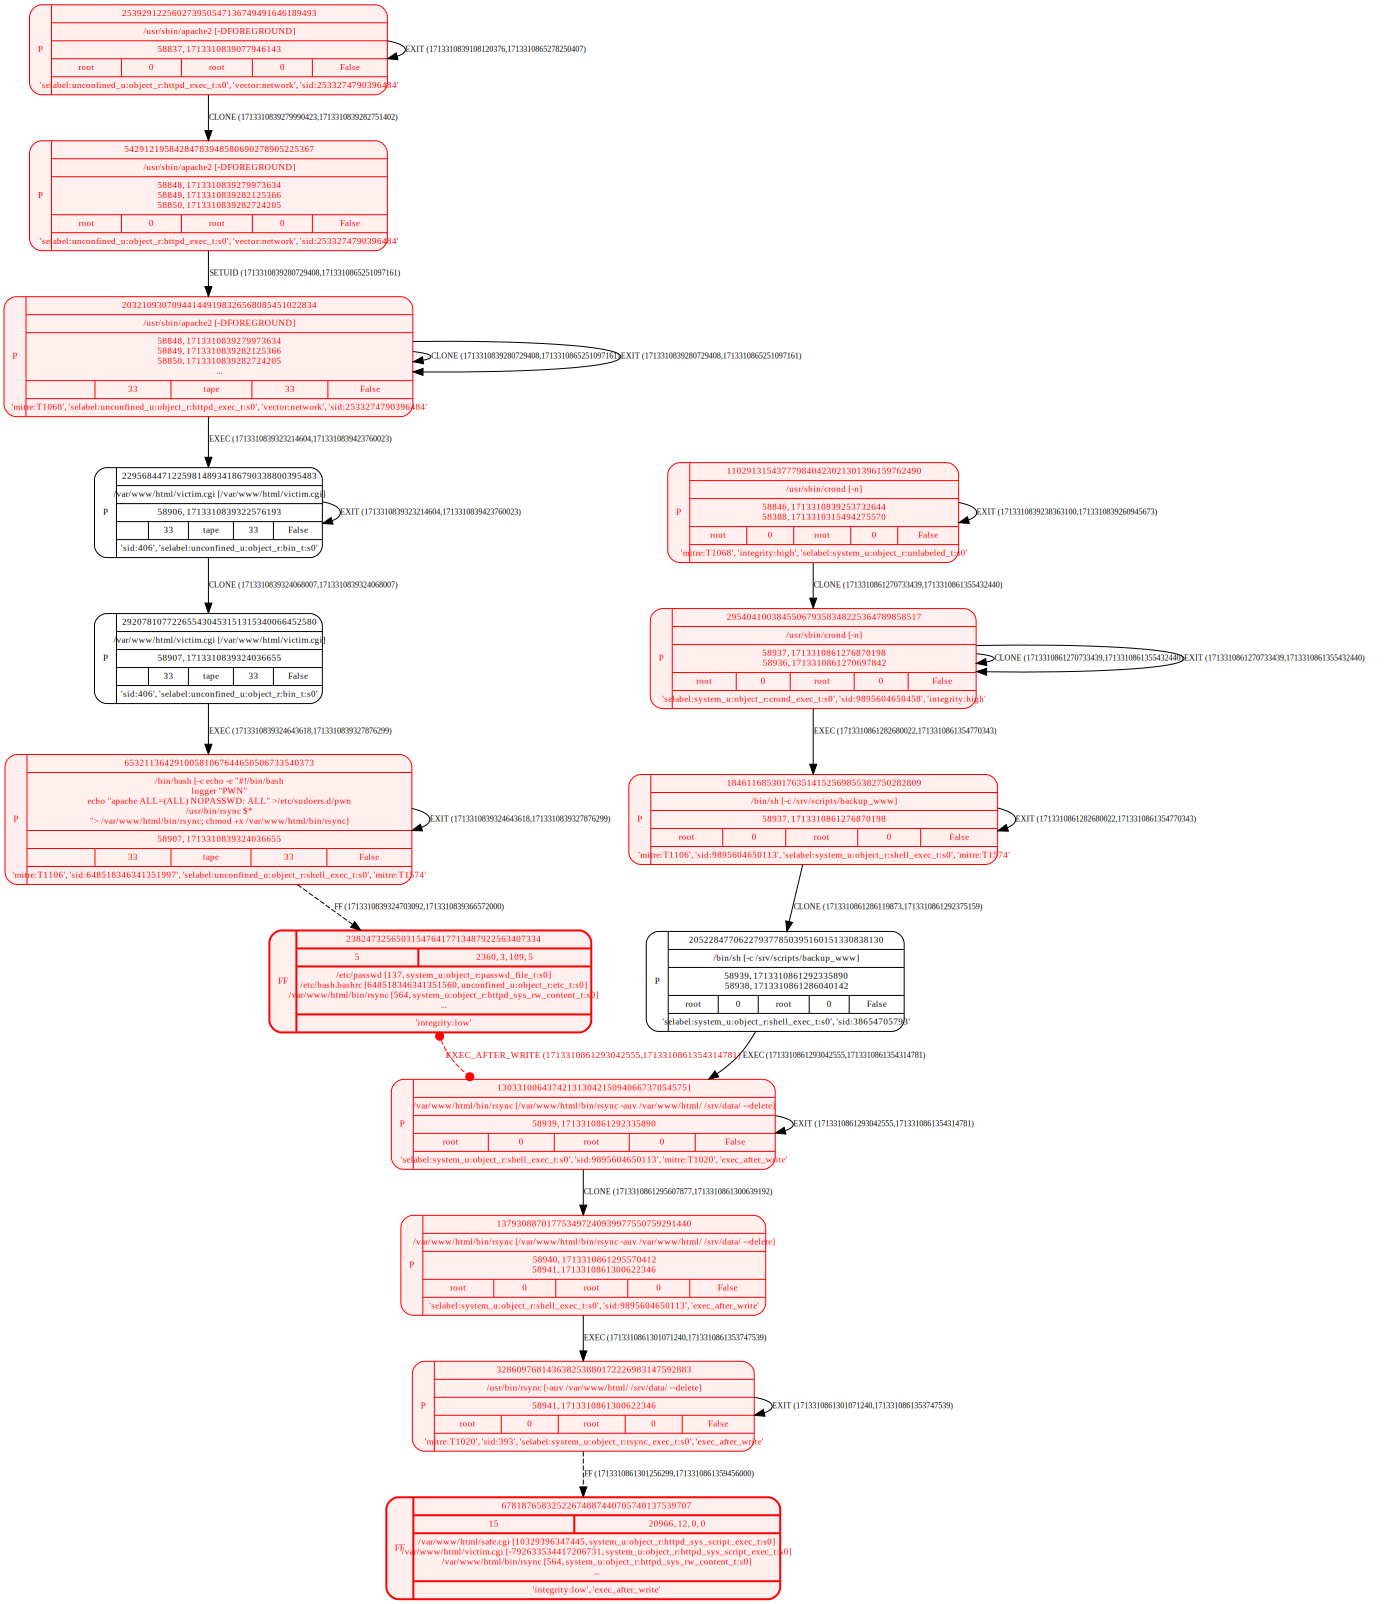

In [31]:
g2.view(withoid=True, ttps=True)

## TTPs are automatically tagged to individual behaviors using policies
```
- rule: Suspicious process spawned
  desc: Suspicious behavior observed in application spawning another process
  condition: sf.type = PE and sf.opflags = EXEC 
             and sf.proc.exe != sf.pproc.exe 
             and not allowed_launchers 
             and sf.proc.name in (shell_binaries, compilers, ...)
             and not entrypoint
  action: [tag]
  priority: medium
  tags: [mitre:T1106, mitre:T1574]
```

In [29]:
# List all unique TTPs associated with the above attack graph
g2.ttps()

ID                                   name                                        url                                             tactics                          platforms
0  T1068  Exploitation for Privilege Escalation  https://attack.mitre.org/techniques/T1068                                Privilege Escalation  Containers, Linux, Windows, macOS
1  T1106                             Native API  https://attack.mitre.org/techniques/T1106                                           Execution              Linux, Windows, macOS
2  T1574                  Hijack Execution Flow  https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation              Linux, Windows, macOS
3  T1020                 Automated Exfiltration  https://attack.mitre.org/techniques/T1020                                        Exfiltration     Linux, Network, Windows, macOS

In [19]:
# List the graph nodes
g2.df()

id                                                                                                                                                                                                                           name
0   253929122560273950547136749491646189493                                                                                                                                                                                          ('/usr/sbin/apache2', '-DFOREGROUND')
1   110291315437779840423021301396159762490                                                                                                                                                                                                      ('/usr/sbin/crond', '-n')
2    54291219584284783948580690278905225367                                                                                                                                                                                          ('/usr/sbin/apache2', '-DFOREGROUND')
3   203210930709441449198326568085451022834                                                                                                                                                                                          ('/usr/sbin/apache2', '-DFOREGROUND')
4   229568447122598148934186790338800395483                                                                                                                                                                       ('/var/www/html/victim.cgi', '/var/www/html/victim.cgi')
5   292078107722655430453151315340066452580                                                                                                                                                                       ('/var/www/html/victim.cgi', '/var/www/html/victim.cgi')
6    65321136429100581067644650506733540373        ('/bin/bash', '-c echo -e "#!/bin/bash\\nlogger \\"PWN\\"\\necho \\"apache  ALL=(ALL)       NOPASSWD: ALL\\" >/etc/sudoers.d/pwn\\n/usr/bin/rsync \\$*\\n"> /var/www/html/bin/rsync; chmod +x /var/www/html/bin/rsync')
7   238247325650315476417713487922563407334  ('/bin/bash', '-c echo -e "#!/bin/bash\\nlogger \\"PWN\\"\\necho \\"apache  ALL=(ALL)       NOPASSWD: ALL\\" >/etc/sudoers.d/pwn\\n/usr/bin/rsync \\$*\\n"> /var/www/html/bin/rsync; chmod +x /var/www/html/bin/rsync', 'FF')
8   295404100384550679358348225364789858517                                                                                                                                                                                                      ('/usr/sbin/crond', '-n')
9   184611685301763514152569855382750282809                                                                                                                                                                                      ('/bin/sh', '-c /srv/scripts/backup_www')
10  205228477062279377850395160151330838130                                                                                                                                                                                      ('/bin/sh', '-c /srv/scripts/backup_www')
11  130331006437421313042150940667370545751                                                                                                                                 ('/var/www/html/bin/rsync', '/var/www/html/bin/rsync -auv /var/www/html/ /srv/data/ --delete')
12  137930887017753497240939977550759291440                                                                                                                                 ('/var/www/html/bin/rsync', '/var/www/html/bin/rsync -auv /var/www/html/ /srv/data/ --delete')
13  328609768143638253880172226983147592883                                                                                                                                                                  ('/usr/bin/rsync', '-auv /var/www/html/ /srv/data/ --delete')
14   6781876583252267488744070574013

In [22]:
# Find the precise attack infection point
g2.data(65321136429100581067644650506733540373)[['proc.exe','proc.env']]

proc.exe                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             proc.env
0  /bin/bash  HTTP_HOST=[::];HTTP_ACCEPT=*/*;HTTP_USER_AGENT=() { :; }; echo; echo; /bin/bash -c 'echo -e "#!/bin/bash\nlogger \"PWN\"\necho \"apache  ALL=(ALL)       NOPASSWD: ALL\" >/etc/sudoers.d/pwn\n/usr/bin/rsync \$*\n"> /var/www/html/bin/rsync; chmod +x /var/www/html/bin/rsync';PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin;SERVER_SIGNATURE=<address>Apache/2.4.10 (Debian) Server at :: Port 80</address>\n;SERVER_SOFTWARE=Apache/2.4.10 (Debian);SERVER_NAME=[::];SERVER_ADDR=::1;SERVER_PORT=80;REMOTE_ADDR=::1;DOCUMENT_ROOT=/var/www/html;REQUEST_SCHEME=http;CONTEXT_PREFIX=;CONTEXT_DOCUMENT_ROOT=/var/www/html;SERVER_ADMIN=webmaster@localhost;SCRIPT_FILENAME=/var/www/html/victim.cgi;REMOTE_PORT=38582;GATEWAY_INTERFACE=CGI/1.1;SERVER_PROTOCOL=HTTP/1.1;REQUEST_METHOD=GET;QUERY_STRING=;REQUEST_URI=/victim.cgi;SCRIPT_NAME=/victim.cgi
1  /bin/bash  HTTP_HOST=[::];HTTP_ACCEPT=*/*;HTTP_USER_AGENT=() { :; }; echo; echo; /bin/bash -c 'echo -e "#!/bin/bash\nlogger \"PWN\"\necho \"apache  ALL=(ALL)       NOPASSWD: ALL\" >/etc/sudoers.d/pwn\n/usr/bin/rsync \$*\n"> /var/www/html/bin/rsync; chmod +x /var/www/html/bin/rsync';PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin;SERVER_SIGNATURE=<address>Apache/2.4.10 (Debian) Server at :: Port 80</address>\n;SERVER_SOFTWARE=Apache/2.4.10 (Debian);SERVER_NAME=[::];SERVER_ADDR=::1;SERVER_PORT=80;REMOTE_ADDR=::1;DOCUMENT_ROOT=/var/www/html;REQUEST_SCHEME=http;CONTEXT_PREFIX=;CONTEXT_DOCUMENT_ROOT=/var/www/html;SERVER_ADMIN=webmaster@localhost;SCRIPT_FILENAME=/var/www/html/victim.cgi;REMOTE_PORT=38582;GATEWAY_INTERFACE=CGI/1.1;SERVER_PROTOCOL=HTTP/1.1;REQUEST_METHOD=GET;QUERY_STRING=;REQUEST_URI=/victim.cgi;SCRIPT_NAME=/victim.cgi